## Importing necessary libraries

In [70]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation

import functions as f
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

np.int = np.int32

from functions import CustomOrdinalEncoder, CustomCategoricalConverter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from feature_engine.encoding import OrdinalEncoder

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

from probatus.feature_elimination import ShapRFECV
import shap

shap.initjs()

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import pickle

## Importing Train and Test sets from Data wrangling Notebook

In [111]:
PATH = "../Data/home-credit-default-risk"
train_set = pd.read_csv(PATH+"/cash_loans_train.csv.zip")
test_set = pd.read_csv(PATH+"/cash_loans_test.csv.zip")

In [112]:
train_set = f.convert_types(train_set, print_info=True)
test_set = f.convert_types(test_set, print_info=True)

Original Memory Usage: 1.05 gb.
New Memory Usage: 0.47 gb.
Original Memory Usage: 0.26 gb.
New Memory Usage: 0.12 gb.


In [113]:
# remove high cardinality categorical features
train_set = train_set.drop(columns=["occupation_type", "organization_type"])
test_set = test_set.drop(columns=["occupation_type", "organization_type"])
selected_col = [
    "cnt_fam_members",
    "cnt_children",
    "obs_30_cnt_social_circle",
    "def_30_cnt_social_circle",
    "obs_60_cnt_social_circle",
    "def_60_cnt_social_circle",
    "amt_req_credit_bureau_hour",
    "amt_req_credit_bureau_day",
    "amt_req_credit_bureau_week",
    "amt_req_credit_bureau_mon",
    "amt_req_credit_bureau_qrt",
    "amt_req_credit_bureau_year",
    "region_rating_client",
    "region_rating_client_w_city",
]
for col in selected_col:
    train_set[col] = train_set[col].astype("Int32")
    train_set[col] = train_set[col].astype("category")
    test_set[col] = test_set[col].astype("Int32")
    test_set[col] = test_set[col].astype("category")


In [114]:
X_train = train_set.drop("target", axis=1)
y_train = train_set["target"]

## Building the Pipeline

In [115]:
order = [
    "Lower secondary",
    "Secondary / secondary special",
    "Incomplete higher",
    "Higher education",
    "Academic degree",
]
order_2 = [
    "MONDAY",
    "TUESDAY",
    "WEDNESDAY",
    "THURSDAY",
    "FRIDAY",
    "SATURDAY",
    "SUNDAY",
]
cat_feat = X_train.select_dtypes("category").columns.tolist()
cat_feat.remove("name_education_type")
cat_feat.remove("weekday_appr_process_start")

preprocess_pipeline = ColumnTransformer(
    transformers=[
        (
            "custom_ordinal_encoder_1",
            CustomOrdinalEncoder(column_name="name_education_type", order=order),
            ["name_education_type"],
        ),
        (
            "custom_ordinal_encoder_2",
            CustomOrdinalEncoder(
                column_name="weekday_appr_process_start", order=order_2
            ),
            ["weekday_appr_process_start"],
        ),
        (
            "cat_encoding",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_feat,
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('custom_ordinal_encoder_1',
                                 CustomOrdinalEncoder(column_name='name_education_type',
                                                      order=['Lower secondary',
                                                             'Secondary / '
                                                             'secondary '
                                                             'special',
                                                             'Incomplete '
                                                             'higher',
                                                             'Higher education',
                                                             'Academic '
                                                             'degree']),
                                 ['name_education_type']),
                                ('custom_ordinal_encoder_2',
                                 CustomOrdinalEncoder(column_name='weekday...
                                  'region_rating_client_w_city',
                                  'reg_region_not_live_region',
                                  'reg_region_not_work_region',
                                  'live_region_not_work_region',
                                  'reg_city_not_live_city',
                                  'reg_city_not_work_city',
                                  'live_city_not_work_city',
                                  'obs_30_cnt_social_circle',
                                  'def_30_cnt_social_circle',
                                  'obs_60_cnt_social_circle',
                                  'def_60_cnt_social_circle', 'flag_document_2',
                                  'flag_document_3', ...])],
                  verbose_feature_names_out=False)

In [116]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [117]:
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_feat),
        ),
    ]
)
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

MODEL EVALUATION ON TRAINING SET


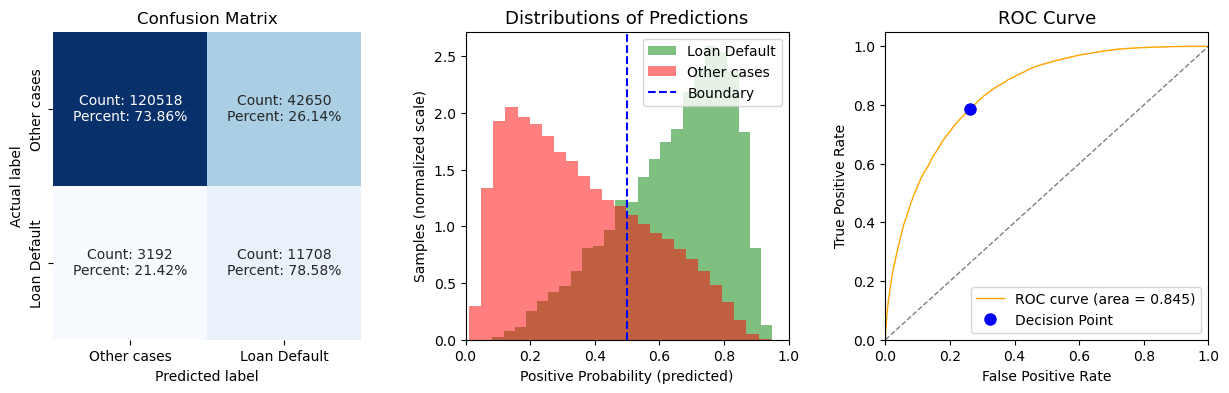

Precision: 0.215 | Recall: 0.786 | F1 Score: 0.338 | AUC: 0.845
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


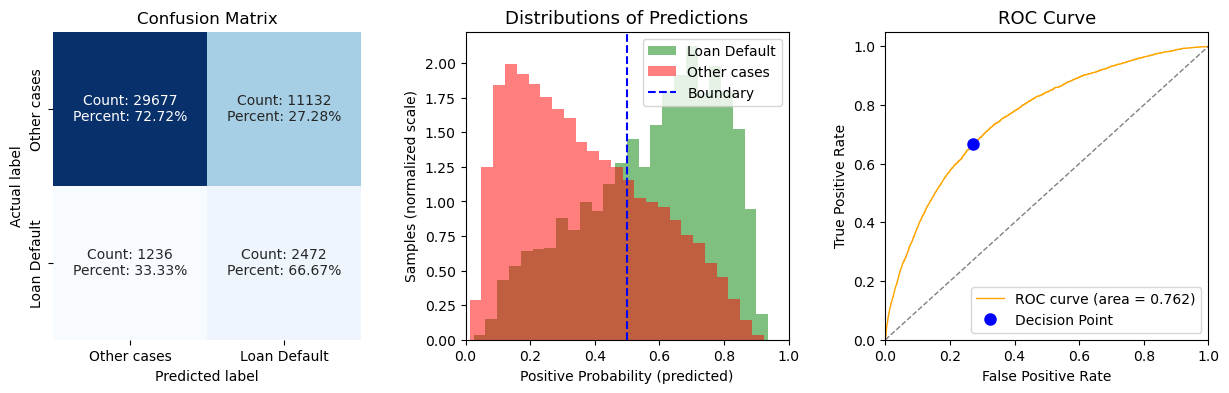

Precision: 0.182 | Recall: 0.667 | F1 Score: 0.286 | AUC: 0.762
------------------------------------------------------------------


In [20]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
classifier = LGBMClassifier(
    random_state=1,
    scale_pos_weight=weight,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
)

classifier.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(
    y_train,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
)
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
)
print("------------------------------------------------------------------")

The models validation AUC score is promising compared to the known scores of models that were submitted to kaggle competition (highest score was around 0.8). But the model overfits because the training and validation scores differ. So I will perform bayesian optimization to tune the hyperparameters of the model.

In [23]:
param_space = {
    "boosting_type": Categorical(["gbdt", "dart"]),
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "n_estimators": Integer(100, 1000),
    "scale_pos_weight": Integer(1, 20),
    "min_child_weight": Integer(0, 10),
    "min_child_samples": Integer(0, 50),
    "max_depth": Integer(1, 50),
    "num_leaves": Integer(2, 100),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "uniform"),
    "reg_alpha": Real(1e-9, 1.0, "log-uniform"),
    "reg_lambda": Real(1e-9, 1000, "log-uniform"),
}
opt = BayesSearchCV(
    classifier,
    param_space,
    scoring="roc_auc",
    n_iter=20,
    cv=3,
    verbose=0,
)
opt.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)

Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stopping is not available in dart mode
Early stop

BayesSearchCV(cv=3,
              estimator=LGBMClassifier(force_col_wise=True, metric='auc',
                                       num_threads=8, objective='binary',
                                       random_state=1,
                                       scale_pos_weight=10.950872483221476,
                                       verbosity=-1),
              n_iter=20, scoring='roc_auc',
              search_spaces={'boosting_type': Categorical(categories=('gbdt', 'dart'), prior=None),
                             'colsample_bytree': Real(low=0.01, high=1.0, prior='uniform', transfo...
                             'num_leaves': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-09, high=1000, prior='log-uniform', transform='normalize'),
                             'scale_pos_weight': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normalize')})

In [24]:
opt.best_params_

OrderedDict([('boosting_type', 'gbdt'),
             ('colsample_bytree', 0.6090563774750625),
             ('learning_rate', 0.025489109946387704),
             ('max_depth', 48),
             ('min_child_samples', 44),
             ('min_child_weight', 7),
             ('n_estimators', 762),
             ('num_leaves', 30),
             ('reg_alpha', 0.2670150096322473),
             ('reg_lambda', 546.5561228571158),
             ('scale_pos_weight', 7),
             ('subsample', 0.5486366417033826)])

MODEL EVALUATION ON TRAINING SET


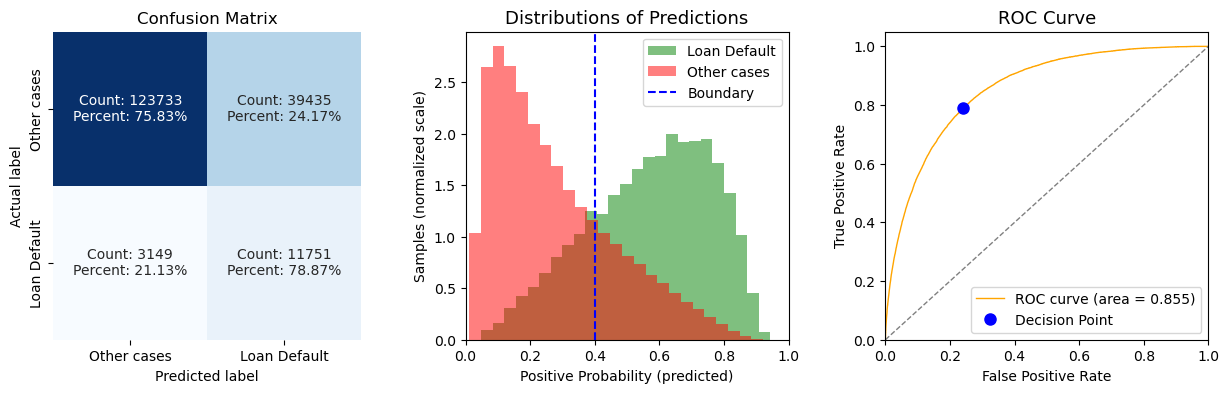

Precision: 0.23 | Recall: 0.789 | F1 Score: 0.356 | AUC: 0.855
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


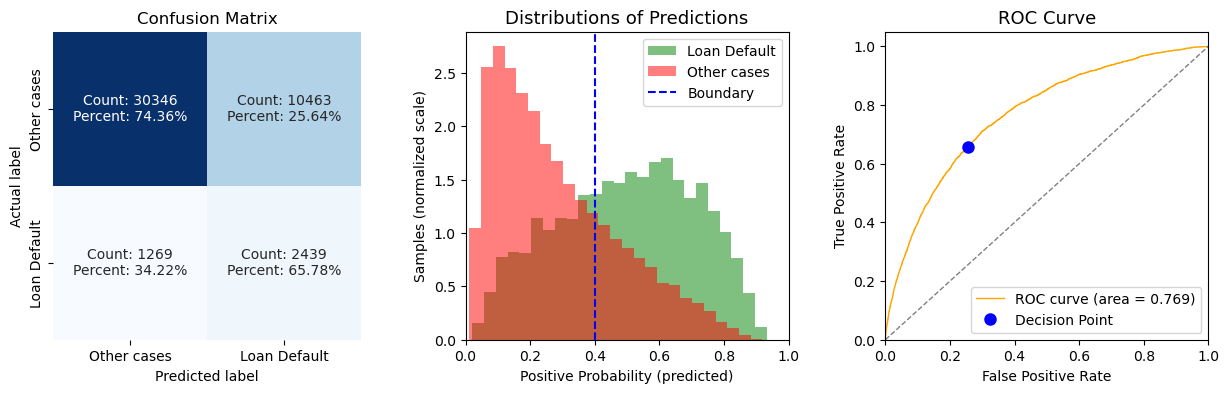

Precision: 0.189 | Recall: 0.658 | F1 Score: 0.294 | AUC: 0.769
------------------------------------------------------------------


In [26]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **opt.best_params_
)

classifier.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(
    y_train,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.4,
)
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.4,
)
print("------------------------------------------------------------------")

From the AUC scores of evaluation on training and validation sets we can see that the hyperparameter tuning did not solve the overfitting problem. So now we will try to improve the model by reducing the number of features using recursive feature selection with shap method.

In [29]:
shap_elimination = ShapRFECV(
    clf=classifier, step=0.2, scoring="roc_auc", n_jobs=-1, verbose=0
)
report = shap_elimination.fit_compute(
    X_train_transformed, y_train, check_additivity=False
)

100%|===================| 35587/35614 [18:39<00:00]        

In [30]:
report[["num_features", "features_set", "val_metric_mean"]]

,num_features,features_set,val_metric_mean
1,589,"[name_education_type, weekday_appr_process_sta...",0.781
2,472,"[name_education_type, weekday_appr_process_sta...",0.781
3,378,"[name_education_type, weekday_appr_process_sta...",0.781
4,303,"[name_education_type, weekday_appr_process_sta...",0.781
5,243,"[name_education_type, weekday_appr_process_sta...",0.782
6,195,"[name_education_type, weekday_appr_process_sta...",0.781
7,156,"[name_education_type, weekday_appr_process_sta...",0.782
8,125,"[name_education_type, weekday_appr_process_sta...",0.782
9,100,"[name_education_type, weekday_appr_process_sta...",0.781
10,80,"[name_education_type, code_gender, flag_own_ca...",0.782


We picked 52 features because with lower number of features the score starts to drop.

In [32]:
final_features_set = shap_elimination.get_reduced_features_set(num_features=52)
features_to_drop = [
    col for col in X_train_transformed.columns if col not in final_features_set
]
X_train_transformed.drop(features_to_drop, axis=1, inplace=True)
X_valid_transformed.drop(features_to_drop, axis=1, inplace=True)

MODEL EVALUATION ON TRAINING SET


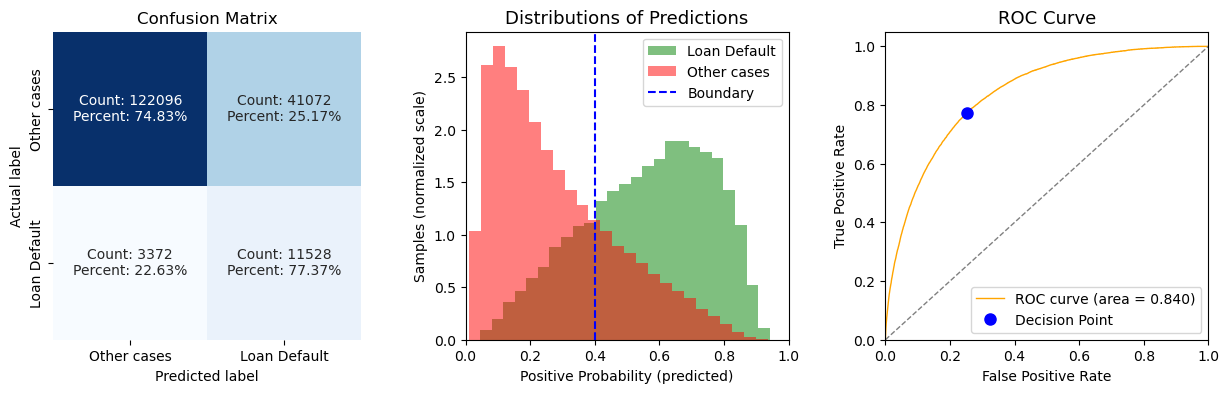

Precision: 0.219 | Recall: 0.774 | F1 Score: 0.342 | AUC: 0.84
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


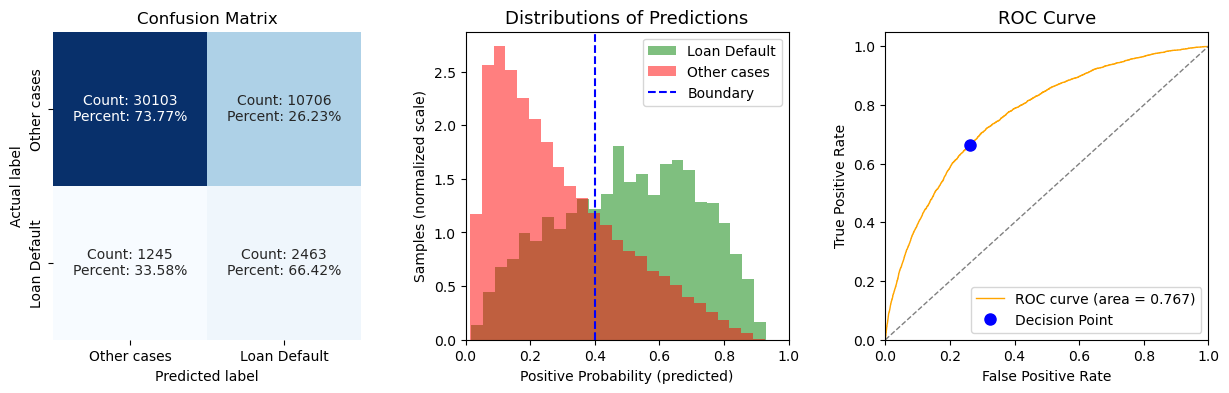

Precision: 0.187 | Recall: 0.664 | F1 Score: 0.292 | AUC: 0.767
------------------------------------------------------------------


In [33]:
classifier.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(
    y_train,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.4
)
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.4
)
print("------------------------------------------------------------------")

In [37]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
)
param_space = {
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "n_estimators": Integer(50, 200),
    "scale_pos_weight": Integer(1, 20),
    "min_child_samples": Integer(0, 50),
    "max_depth": Integer(1, 10),
    "num_leaves": Integer(2, 100),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.3, 1.0, "uniform"),
    "min_gain_to_split": Real(0.0, 1.0, "uniform"),
    "reg_lambda": Real(1e-8, 1000, "log-uniform"),
}
opt = BayesSearchCV(
    classifier,
    param_space,
    scoring="roc_auc",
    n_iter=20,
    cv=3,
    verbose=0,
)
opt.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)

BayesSearchCV(cv=3,
              estimator=LGBMClassifier(force_col_wise=True, metric='auc',
                                       num_threads=8, objective='binary',
                                       random_state=1, verbosity=-1),
              n_iter=20, scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.3, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_d...
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-08, high=1000, prior='log-uniform', transform='normalize'),
                             'scale_pos_weight': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normalize')})

In [40]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **opt.best_params_
)
shap_elimination = ShapRFECV(
    clf=classifier, step=0.2, scoring="roc_auc", n_jobs=-1, verbose=0
)
report = shap_elimination.fit_compute(
    X_train_transformed, y_train, check_additivity=False
)

 91%|==================  | 32377/35614 [00:13<00:01]       

In [41]:
report[["num_features", "features_set", "val_metric_mean"]]

,num_features,features_set,val_metric_mean
1,52,"[name_education_type, code_gender, flag_own_ca...",0.776
2,42,"[name_education_type, code_gender, flag_own_ca...",0.775
3,34,"[name_education_type, code_gender, flag_own_ca...",0.773
4,28,"[name_education_type, code_gender, flag_own_ca...",0.773
5,23,"[name_education_type, code_gender, flag_own_ca...",0.770
6,19,"[name_education_type, code_gender, flag_own_ca...",0.767
7,16,"[name_education_type, code_gender, flag_own_ca...",0.764
8,13,"[name_education_type, code_gender, amt_credit,...",0.761
9,11,"[name_education_type, amt_credit, amt_goods_pr...",0.758
10,9,"[amt_credit, amt_goods_price, days_employed, e...",0.754


to try to even more reduce the overfitting and also have a better explainability of the model we picked top 16 features as our final set.

In [42]:
final_features_set = shap_elimination.get_reduced_features_set(num_features=16)
features_to_drop = [
    col for col in X_train_transformed.columns if col not in final_features_set
]
X_train_transformed.drop(features_to_drop, axis=1, inplace=True)
X_valid_transformed.drop(features_to_drop, axis=1, inplace=True)

## Calibrating the model

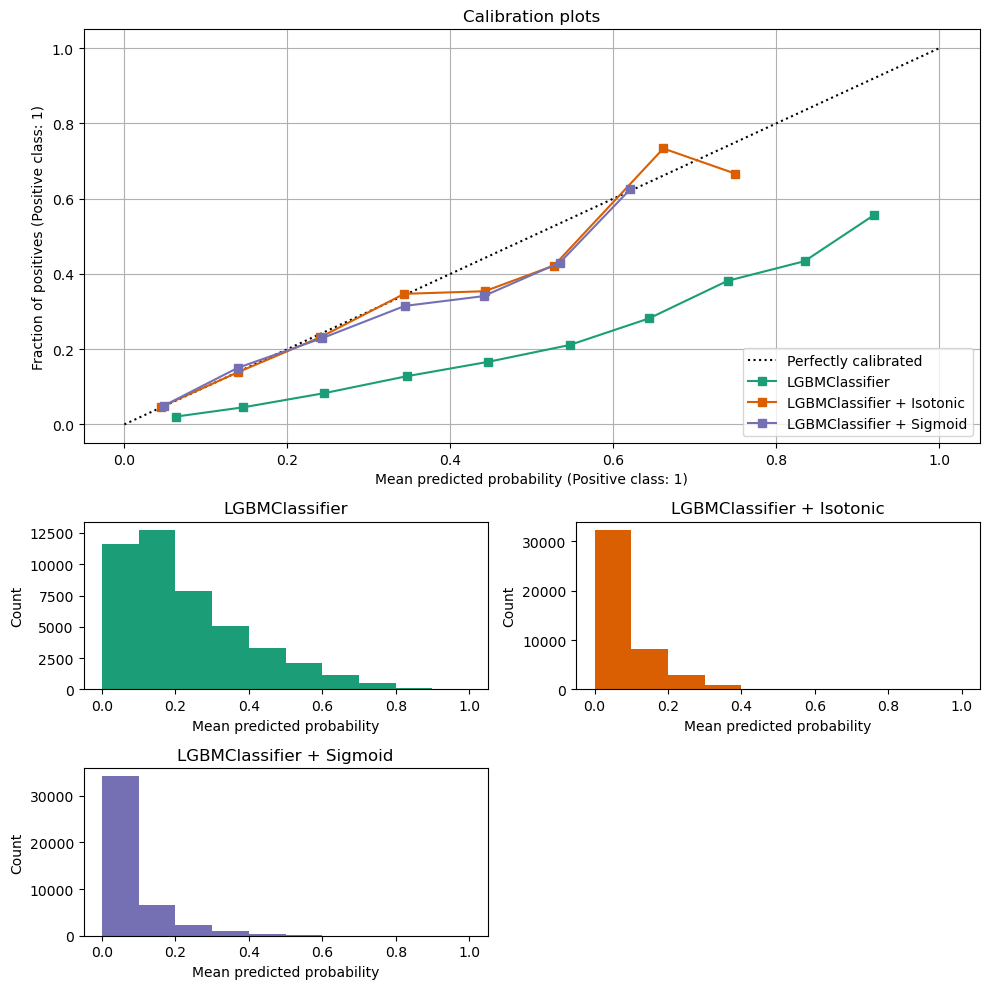

In [119]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **opt.best_params_
)
lgbm_isotonic = CalibratedClassifierCV(classifier, cv=2, method="isotonic")
lgbm_sigmoid = CalibratedClassifierCV(classifier, cv=2, method="sigmoid")

clf_list = [
    (classifier, "LGBMClassifier"),
    (lgbm_isotonic, "LGBMClassifier + Isotonic"),
    (lgbm_sigmoid, "LGBMClassifier + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_transformed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_valid_transformed,
        y_valid,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Final pipeline

In [120]:
cat_feat = [
    "code_gender",
    "flag_own_car",
    "mode_installments_payments_previous_application_product_combination",
]
best_params = {
    "colsample_bytree": 0.9890984985798228,
    "learning_rate": 0.16527467365373438,
    "max_depth": 4,
    "min_child_samples": 39,
    "min_gain_to_split": 0.8695785554582836,
    "n_estimators": 162,
    "num_leaves": 99,
    "reg_lambda": 9.467421370288077e-05,
    "scale_pos_weight": 4,
    "subsample": 0.8654297795674902,
}
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **best_params
)
features_to_drop = [col for col in X_train.columns if col not in final_features_set]
X_train.drop(features_to_drop, axis=1, inplace=True)

In [121]:
pre_pipeline = ColumnTransformer(
    transformers=[
        (
            "custom_ordinal_encoder",
            CustomOrdinalEncoder(column_name="name_education_type", order=order),
            ["name_education_type"],
        ),
        (
            "cat_encoder",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_feat,
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
pre_pipeline.set_output(transform="pandas")
final_pipeline = Pipeline(
    steps=[
        ("preprocess", pre_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_feat),
        ),
        (
            "calibrated_classifier",
            CalibratedClassifierCV(classifier, cv=2, method="isotonic"),
        ),
    ]
)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('custom_ordinal_encoder',
                                                  CustomOrdinalEncoder(column_name='name_education_type',
                                                                       order=['Lower '
                                                                              'secondary',
                                                                              'Secondary '
                                                                              '/ '
                                                                              'secondary '
                                                                              'special',
                                                                              'Incomplete '
                                                                              'higher',
                                                                              'Higher '
                                                                              'education',
                                                                              'Academic '
                                                                              'degree']),
                                                  ['name_education_type']),
                                                 ('cat_encoder',
                                                  OrdinalEncoder(encod...
                                        estimator=LGBMClassifier(colsample_bytree=0.9890984985798228,
                                                                 force_col_wise=True,
                                                                 learning_rate=0.16527467365373438,
                                                                 max_depth=4,
                                                                 metric='auc',
                                                                 min_child_samples=39,
                                                                 min_gain_to_split=0.8695785554582836,
                                                                 n_estimators=162,
                                                                 num_leaves=99,
                                                                 num_threads=8,
                                                                 objective='binary',
                                                                 random_state=1,
                                                                 reg_lambda=9.467421370288077e-05,
                                                                 scale_pos_weight=4,
                                                                 subsample=0.8654297795674902,
                                                                 verbosity=-1),
                                        method='isotonic'))])

MODEL EVALUATION ON VALIDATION SET


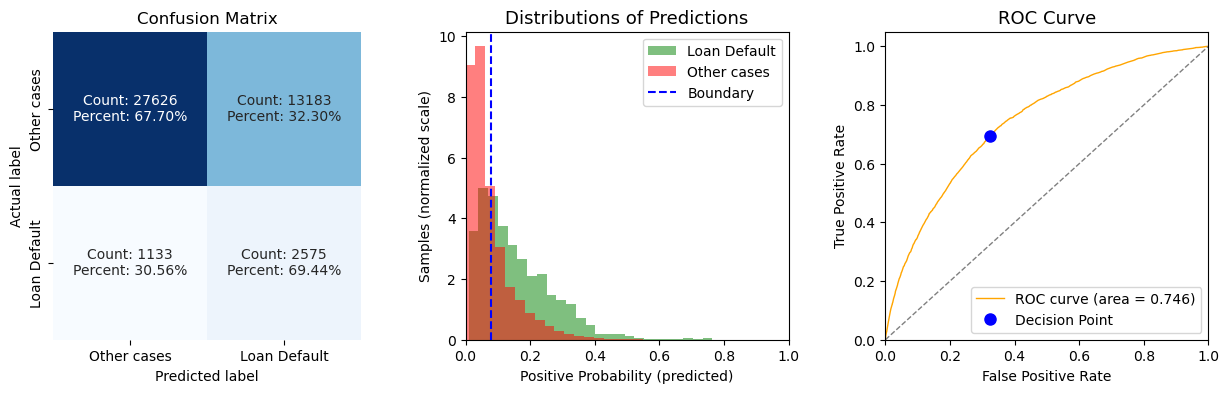

Precision: 0.163 | Recall: 0.694 | F1 Score: 0.265 | AUC: 0.746


In [122]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = final_pipeline.predict_proba(X_valid)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.08,
)

## Final evaluation on Test set

In [123]:
X_test = test_set.drop("target", axis=1)
y_test = test_set["target"]
features_to_drop = [col for col in X_test.columns if col not in final_features_set]
X_test.drop(features_to_drop, axis=1, inplace=True)

MODEL EVALUATION ON TEST SET


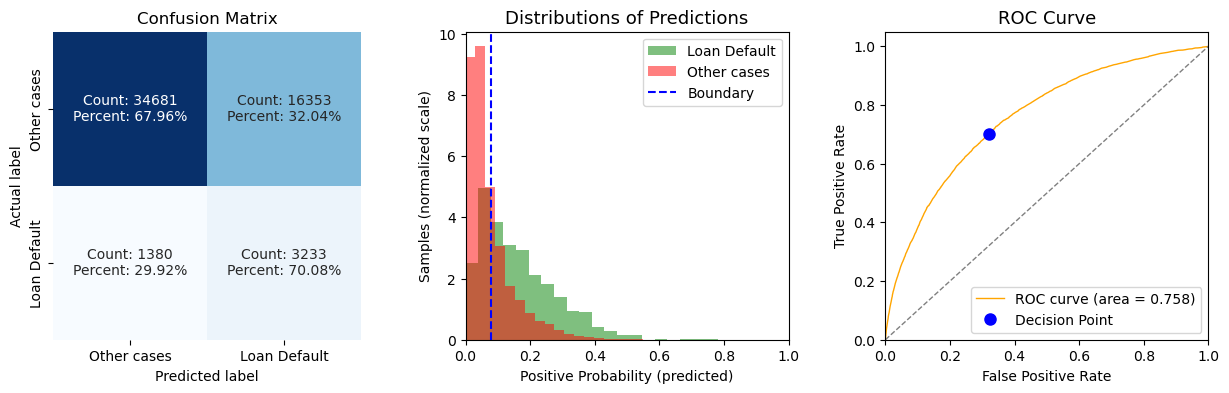

Precision: 0.165 | Recall: 0.701 | F1 Score: 0.267 | AUC: 0.758


In [124]:
print("MODEL EVALUATION ON TEST SET")
y_pred = final_pipeline.predict_proba(X_test)
f.binary_performances(
    y_test,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.08,
)

In [125]:
final_pipeline.score(X_test, y_test)

0.9173001239959028

Now we can calculate how much money our model would prevent the bank from losing by default loans. This could be achieved by multiplying the number of TP (True Positives) by the average credit amount of the default loans group which is 578k. As a result we get **1.9 billion** in total. Also we can approximate the amount of money the bank will lose if there are a lot of misclassified default loans (False positives). This could be achieved by multiplying the number of FP by the average credit amount of the non-default loans group which is 632k and also the interest rate which could be 5% in this case. So as a result we get **500 million** of profit that could be lost due to misclassification. So overall the bank should be able to avoid big losses by predicting the default loans. But also the drawback is that there would be loses to the profit gained by the interest rate of the non-default loans.

## Saving the final model

In [126]:
# with open("cash_loan_default-0.1.0.pkl", "wb") as f:
#     pickle.dump(final_pipeline, f)